In [1]:
import glob
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import qcopt
from qcopt.utils.helper_funcs import hamming_weight

matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)
#plt.rcParams["font.family"] = "TNR"

# Data loading

In [2]:
def load_qaoa_data(alg, graphtype, k=1, graphsize=20):
    all_graph_dirs = sorted(glob.glob(f"benchmark_results/{alg}/N{graphsize}_{graphtype}_graphs/G*"))
    all_data = []
    for graph_dir in all_graph_dirs:
        pickle_files = glob.glob(f"{graph_dir}/*pickle")
        
        # sort the runs based on the final cost of the objective function
        all_pickles = []
        for pkl_file in pickle_files:
            with open(pkl_file, 'rb') as pkl:
                data = pickle.load(pkl)
            all_pickles.append(data)

        all_pickles = sorted(all_pickles, key=lambda p: hamming_weight(p['out']['best_indset']), reverse=True)

        # save the results of the best k runs
        for sim in all_pickles[:k]:
            all_data.append(sim)
    
    return all_data

def load_dqva_data(alg, graphtype, k=1, graphsize=20):
    all_graph_dirs = sorted(glob.glob(f"benchmark_results/{alg}/N{graphsize}_{graphtype}_graphs/G*"))
    all_data = []
    for graph_dir in all_graph_dirs:
        pickle_files = glob.glob(f"{graph_dir}/*pickle")
        
        # sort the runs based on the size of the final independent set
        all_pickles = []
        for pkl_file in pickle_files:
            with open(pkl_file, 'rb') as pkl:
                data = pickle.load(pkl)
            all_pickles.append(data)

        all_pickles = sorted(all_pickles, key=lambda p: hamming_weight(p['out'][0]), reverse=True)

        # save the results of the best k runs
        for sim in all_pickles[:k]:
            all_data.append(sim)
    
    return all_data

In [3]:
def get_approximation_ratio(graph_filename, final_mis_state):
    graph_type = graph_filename.split('/')[-2]
    graph_name = graph_filename.split('/')[-1].strip('.txt')
    optimal_bitstrings = []
    with open(f"benchmark_graphs/brute_force_outputs/{graph_type}/{graph_name}_brute_force.out") as brute_force_file:
        for i, line in enumerate(brute_force_file):
            if i == 1:
                optimal_mis = int(line.split()[-1])
                break

    return hamming_weight(final_mis_state) / optimal_mis

# Comparison of single-angle and multi-angle QAOA

In [115]:
def plot_sa_ma_qaoa_comparison(d3_data, p20_data, p50_data, p80_data):
    """Compare the approximation ratios of p=10, 11 SA-QAOA and p=1 MA-QAOA"""
    fig, ax = plt.subplots(dpi=150)
    width = 0.25
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i, all_data in enumerate([d3_data, p20_data, p50_data, p80_data]):
        for j, (label, data) in enumerate(all_data.items()):
            # compute the approximation ratios
            approx_ratios = []
            for sim_output in data:
                approx_ratios.append(get_approximation_ratio(sim_output['graph'], sim_output['out']['best_indset']))
            
            # plot the mean, max, and min values
            if j == 0:
                align = 'edge'
                effective_width = width
                xval = i - width
            elif j == 1:
                align = 'center'
                effective_width = width
                xval = i
            elif j == 2:
                align = 'edge'
                effective_width = -width
                xval = i + width
            yval = np.mean(approx_ratios)
            min_err = yval - np.min(approx_ratios)
            max_err = np.max(approx_ratios) - yval
            ax.bar(xval, yval, yerr=[[min_err], [max_err]], width=effective_width, capsize=5, color=colors[j])
    
    ax.set_ylim([0.7, 1.02])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['3-regular', 'P=20%\nErdos-Renyi', 'P=50%\nErdos-Renyi', 'P=80%\nErdos-Renyi'], fontsize=10)
    ax.set_ylabel('Approximation Ratio', fontsize=13)
    
    custom_lines = [matplotlib.lines.Line2D([0], [0], color=color, lw=4) for color in colors]
    ax.legend(custom_lines, ['$p=10$ SA-QAOA', '$p=11$ SA-QAOA', '$p=1$   MA-QAOA'], framealpha=1)

In [140]:
d3_data = {'p=5, SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'd3'),
           'p=10, SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'd3'),
           'p=11, SA-QAOA': load_qaoa_data('qaoa_IPM0_P11', 'd3'),
           'p=1, MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'd3')}
p20_data = {'p=5, SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'p20'),
            'p=10, SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'p20'),
            'p=11, SA-QAOA': load_qaoa_data('qaoa_IPM0_P11', 'p20'),
            'p=1, MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'p20')}
p50_data = {'p=5, SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'p50'),
            'p=10, SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'p50'),
            'p=11, SA-QAOA': load_qaoa_data('qaoa_IPM0_P11', 'p50'),
            'p=1, MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'p50')}
p80_data = {'p=5, SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'p80'),
            'p=10, SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'p80'),
            'p=11, SA-QAOA': load_qaoa_data('qaoa_IPM0_P11', 'p80'),
            'p=1, MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'p80')}

In [141]:
print(d3_data['p=10, SA-QAOA'][0])

{'graph': '/n/fs/qcteague/quantum-constrained-optimization/benchmark_graphs/N20_d3_graphs/G1.txt', 'out': {'best_indset': '11010000010010010111', 'cost': -8.962851100000004, 'function_evals': 1000, 'init_state': '00000000000000000000', 'mixer_order': [1, 16, 7, 2, 11, 15, 8, 0, 9, 19, 3, 5, 13, 18, 10, 14, 4, 17, 12, 6], 'num_params': 20, 'opt_params': array([ 0.37432044,  3.30666902,  6.18266091,  4.02447336,  0.36281154,
        2.28350863,  5.58619726, -0.41983156,  0.93505165,  4.07086319,
        6.3065637 ,  5.03013819,  5.57972036,  1.36906972,  6.00726935,
        2.1802518 ,  3.13953464,  5.92314774,  1.5726251 ,  3.58468425]), 'P': 10, 'individual_partial_mixers': False}}


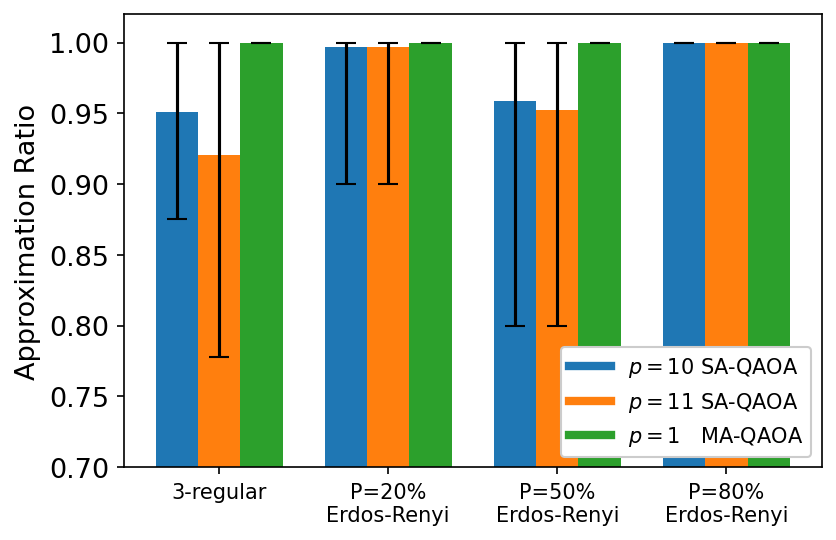

In [116]:
plot_sa_ma_qaoa_comparison(d3_data, p20_data, p50_data, p80_data)

# Cross-algorithm performance comparison

In [25]:
def plot_performance(d3_data, p20_data, p50_data, p80_data, savefig=None):
    """Compare the approximation ratios of SA-QAOA, MA-QAOA and DQVA"""
    fig, ax = plt.subplots(figsize=[22,5], nrows=1, ncols=2, sharey=True)
    color_dict = {'SA-QAOA':'#0093d6', 'MA-QAOA':'#fc70be', 'DQVA':'#ffa600'}
    graphs = ['3-regular', 'Erdős-Rényi (50%)']
    
    for i, all_data in enumerate([d3_data, p50_data]):
        # Generate box plots for the current graph type
        violin_data = []
        for j, (label, data) in enumerate(all_data.items()):
            # compute the approximation ratios
            approx_ratios = []
            for sim_output in data:
                if 'QAOA' in label:
                    soln_bitstr = sim_output['out']['best_indset']
                elif 'DQVA' in label:
                    soln_bitstr = sim_output['out'][0]
                approx_ratios.append(get_approximation_ratio(sim_output['graph'], soln_bitstr))
            
            violin_data.append((label, approx_ratios))

        # box plots
        labels = [t[0] for t in violin_data]
        dataset = [t[1] for t in violin_data]
        positions = list(range(1, len(all_data)+1))
        yvals = [np.mean(d) for d in dataset]
        min_err = [mean_val - np.min(d) for mean_val, d in zip(yvals, dataset)]
        max_err = [np.max(d) - mean_val for mean_val, d in zip(yvals, dataset)]
        colors = [color_dict[label.split()[-1]] for label in labels]
        if True:
            
            ax[i].bar(positions, yvals, yerr=[min_err, max_err], color=colors, capsize=5)
            print()
        else:
            violin_parts = ax[i].violinplot(dataset, showmeans=True, positions=positions)

            for j, body in enumerate(violin_parts['bodies']):
                body.set_facecolor(color_dict[labels[j].split()[-1]])
                body.set_edgecolor('black')
            violin_parts['cmeans'].set_color('black')
            violin_parts['cmins'].set_color('black')
            violin_parts['cmaxes'].set_color('black')
            violin_parts['cbars'].set_color('black')
        ticklabels = [l.split()[0] for l in labels]
        print('SA-QAOA:')
        print([f'{p}, AR = {ar:.3f}%' for p, ar in zip(ticklabels[:4], yvals[:4])])
        print('MA-QAOA:')
        print(f'{ticklabels[4]}, AR = {yvals[4]:.3f}%')
        print('DQVA:')
        print([f'{nu}, AR = {ar:.3f}%' for nu, ar in zip(ticklabels[5:], yvals[5:])])
        ax[i].tick_params(axis='both', labelsize=18)
        ax[i].set_xticks(positions)
        ax[i].set_xticklabels([l.split()[0] for l in labels], rotation=45)
        ax[i].set_xlabel(graphs[i], fontsize=20)
    
    ax[0].set_ylabel('Approximation Ratio', fontsize=20)
    ax[0].set_ylim([0.79, 1.01])
    
    custom_lines = [matplotlib.lines.Line2D([0], [0], color=color, lw=4) for color in color_dict.values()]
    leg = fig.legend(custom_lines, ['SA-QAOA', 'MA-QAOA', 'DQVA'], ncol=3, fontsize=20, loc=(0.0,0.0), bbox_to_anchor=(0.38, 0.98))
    
    leg.set_in_layout(True)
    
    fig.tight_layout()
    
    if savefig:
        plt.savefig(savefig, bbox_extra_artists=(leg,), bbox_inches='tight')

In [5]:
k = 1
d3_data = {'$p=1$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P1', 'd3', k=k),
           #'$p=2$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P2', 'd3', k=k),
           '$p=3$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P3', 'd3', k=k),
           #'$p=4$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P4', 'd3', k=k),
           '$p=5$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'd3', k=k),
           '$p=10$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'd3', k=k),
           '$p=1$ MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'd3', k=k),
           r'$\nu=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'd3', k=k),
           r'$\nu=7$ DQVA': load_dqva_data('dqva_7_partial_mixers', 'd3', k=k),
           r'$\nu=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'd3', k=k),
           r'$\nu=12$ DQVA': load_dqva_data('dqva_12_partial_mixers', 'd3', k=k),
           r'$\nu=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'd3', k=k),
           r'$\nu=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'd3', k=k)}

#p20_data = {'$p=1$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P1', 'p20', k=k),
#            '$p=5$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'p20', k=k),
#            '$p=10$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'p20', k=k),
#            #'$p=11$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P11', 'p20', k=k),
#            '$p=1$ MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'p20', k=k),
#            '$n_p=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'p20', k=k),
#            '$n_p=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'p20', k=k),
#            '$n_p=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'p20', k=k),
#            '$n_p=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'p20', k=k)}

p50_data = {'$p=1$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P1', 'p50', k=k),
            #'$p=2$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P2', 'p50', k=k),
            '$p=3$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P3', 'p50', k=k),
            #'$p=4$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P4', 'p50', k=k),
            '$p=5$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'p50', k=k),
            '$p=10$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'p50', k=k),
            '$p=1$ MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'p50', k=k),
            r'$\nu=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'p50', k=k),
            r'$\nu=7$ DQVA': load_dqva_data('dqva_7_partial_mixers', 'p50', k=k),
            r'$\nu=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'p50', k=k),
            r'$\nu=12$ DQVA': load_dqva_data('dqva_12_partial_mixers', 'p50', k=k),
            r'$\nu=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'p50', k=k),
            r'$\nu=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'p50', k=k)}

#p80_data = {'$p=1$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P1', 'p80', k=k),
#            '$p=5$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'p80', k=k),
#            '$p=10$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'p80', k=k),
#            #'$p=11$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P11', 'p80', k=k),
#            '$p=1$ MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'p80', k=k),
#            '$n_p=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'p80', k=k),
#            '$n_p=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'p80', k=k),
#            '$n_p=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'p80', k=k),
#            '$n_p=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'p80', k=k),}


SA-QAOA:
['$p=1$, AR = 0.976%', '$p=3$, AR = 0.991%', '$p=5$, AR = 0.987%', '$p=10$, AR = 0.996%']
MA-QAOA:
$p=1$, AR = 1.000%
DQVA:
['$\\nu=5$, AR = 0.964%', '$\\nu=7$, AR = 0.980%', '$\\nu=10$, AR = 0.982%', '$\\nu=12$, AR = 0.982%', '$\\nu=14$, AR = 0.989%', '$\\nu=18$, AR = 1.000%']

SA-QAOA:
['$p=1$, AR = 0.997%', '$p=3$, AR = 0.993%', '$p=5$, AR = 0.996%', '$p=10$, AR = 0.997%']
MA-QAOA:
$p=1$, AR = 1.000%
DQVA:
['$\\nu=5$, AR = 0.986%', '$\\nu=7$, AR = 0.983%', '$\\nu=10$, AR = 0.997%', '$\\nu=12$, AR = 1.000%', '$\\nu=14$, AR = 1.000%', '$\\nu=18$, AR = 1.000%']


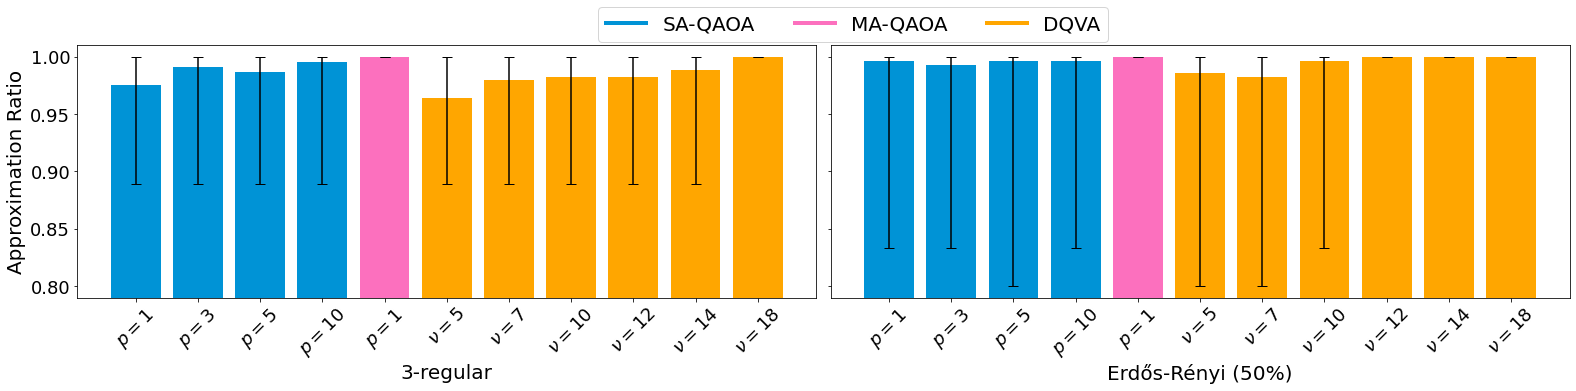

In [27]:
plot_performance(d3_data, None, p50_data, None, savefig='figures/ACM/p_and_nu_approx_ratios.pdf')

# Quantify the classical vs quantum resource tradeoff for DQVA
The DQVA allows fewer quantum gates to be used in the variational optimizations. This comes at the cost of additional rounds of optimization
that need to be performed. For our simulations we set the number of rounds equal to 6, but how many rounds is enough?

Plot the average approximation ratio for DQVA with varying numbers of partial mixers as a function of the mixer round.

In [50]:
def plot_dqva_rounds(d3_data, p20_data, p50_data, p80_data, savefig=None):
    fig, ax = plt.subplots(figsize=[22,7], nrows=1, ncols=2, sharey=True)
    #color_dict = {'$n_p=5$ DQVA':'tab:blue', '$n_p=10$ DQVA':'tab:orange', '$n_p=14$ DQVA':'tab:green', '$n_p=18$ DQVA':'tab:red'}
    graphs = ['3-regular', 'Erdős-Rényi (50%)']
    
    for i, all_data in enumerate([d3_data, p50_data]):
        # all_data has the info needed to construct Plot i
        for j, (label, data) in enumerate(all_data.items()):
            # Each element of all_data corresponds to a different number of partial mixers
            # Compute the average approximation ratio over MIXER rounds
            # We will average over MIXER rounds because there are a fixed number while
            # each simulation might have a variable number of inner rounds.
            # An additional figure could show the average number of inner rounds per mixer rounds
            approx_ratios = []
            for sim_output in data:
                final_mis, _, _, _, history = sim_output['out']
                sim_approx_ratios = []
                for mixer_round in history:
                    # The output state of each mixer round is always the INITIAL state of the last inner round
                    sim_approx_ratios.append(get_approximation_ratio(sim_output['graph'], mixer_round[-1]['init_state']))
                approx_ratios.append(sim_approx_ratios)

            approx_ratios = np.array(approx_ratios)
            avg_approx_ratios = np.mean(approx_ratios, axis=0)
            stderr = np.std(approx_ratios, axis=0) / np.sqrt(approx_ratios.shape[0])
            
            ax[i].plot(list(range(1,approx_ratios.shape[1]+1)), avg_approx_ratios, lw=3, marker='o', label=label)
            ax[i].grid(visible=True)
        
        # Plot SA-QAOA and MA-QAOA results
        if i == 0:
            saqaoa = 0.996
            maqaoa = 1.0
        elif i == 1:
            saqaoa = 0.997
            maqaoa = 1.0
        ax[i].axhline(saqaoa, label=r'$p=10$ SA-QAOA', ls='--', color='#0093d6')
        ax[i].axhline(maqaoa, label=r'$p=1$ MA-QAOA', ls='--', color='#fc70be')
    
    ax[0].set_ylabel('Approximation Ratio', fontsize=20)
    #ax[0].set_ylim([0.74, 1.01])
    
    #custom_lines = [matplotlib.lines.Line2D([0], [0], color=color, lw=4) for color in color_dict.values()]
    #ax[0].legend(custom_lines, [key.strip(' DQVA') for key in color_dict.keys()], ncol=1, fontsize=16)
    ax[0].legend(fontsize=16)
    
    for axes, graph in zip(ax, graphs):
        axes.set_xlabel(f'Mixer Rounds, {graph} graphs', fontsize=18)
        axes.tick_params(axis='both', labelsize=18)
    
    #leg.set_in_layout(True)
    
    fig.tight_layout()
    
    if savefig:
        plt.savefig(savefig)

In [104]:
k = 1
d3_data = {r'$\nu=4$ DQVA': load_dqva_data('dqva_4_partial_mixers', 'd3', k=k),
           r'$\nu=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'd3', k=k),
           r'$\nu=6$ DQVA': load_dqva_data('dqva_6_partial_mixers', 'd3', k=k),
           r'$\nu=7$ DQVA': load_dqva_data('dqva_7_partial_mixers', 'd3', k=k),
           r'$\nu=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'd3', k=k),
           r'$\nu=12$ DQVA': load_dqva_data('dqva_12_partial_mixers', 'd3', k=k),
           r'$\nu=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'd3', k=k),
           r'$\nu=16$ DQVA': load_dqva_data('dqva_16_partial_mixers', 'd3', k=k),
           r'$\nu=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'd3', k=k)}

#p20_data = {'$n_p=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'p20', k=k),
#            '$n_p=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'p20', k=k),
#            '$n_p=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'p20', k=k),
#            '$n_p=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'p20', k=k)}

p50_data = {r'$\nu=4$ DQVA': load_dqva_data('dqva_4_partial_mixers', 'p50', k=k),
            r'$\nu=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'p50', k=k),
            r'$\nu=6$ DQVA': load_dqva_data('dqva_6_partial_mixers', 'p50', k=k),
            r'$\nu=7$ DQVA': load_dqva_data('dqva_7_partial_mixers', 'p50', k=k),
            r'$\nu=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'p50', k=k),
            r'$\nu=12$ DQVA': load_dqva_data('dqva_12_partial_mixers', 'p50', k=k),
            r'$\nu=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'p50', k=k),
            r'$\nu=16$ DQVA': load_dqva_data('dqva_16_partial_mixers', 'p50', k=k),
            r'$\nu=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'p50', k=k)}

#p80_data = {'$n_p=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'p80', k=k),
#            '$n_p=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'p80', k=k),
#            '$n_p=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'p80', k=k),
#            '$n_p=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'p80', k=k),}

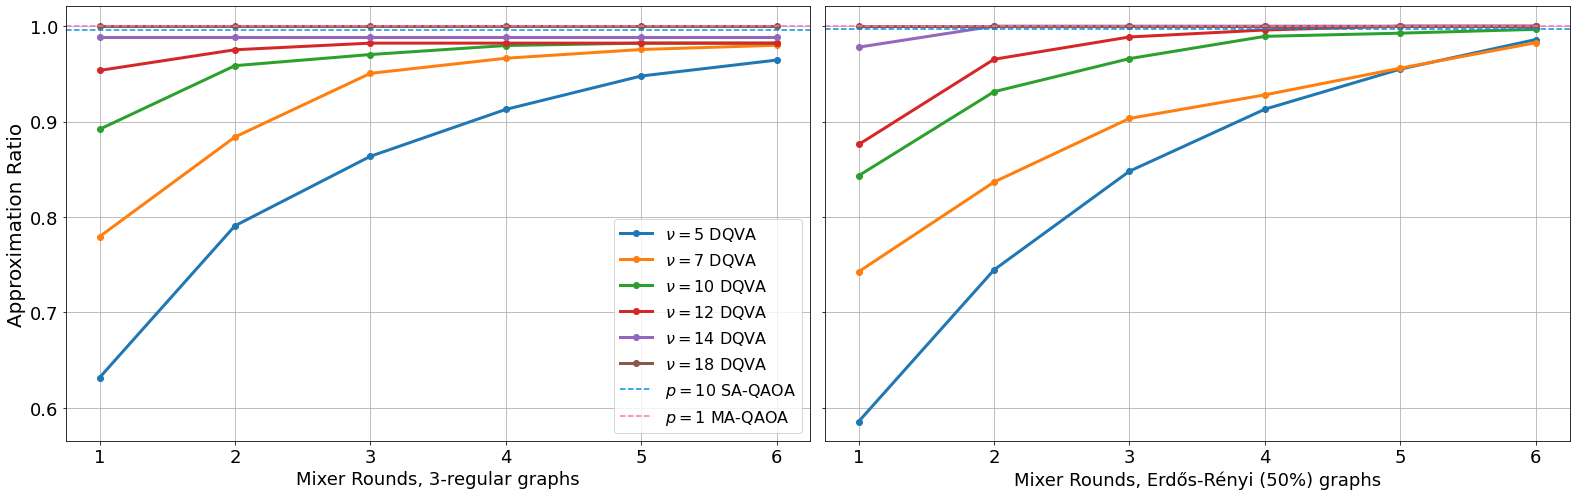

In [52]:
plot_dqva_rounds(d3_data, None, p50_data, None, savefig='figures/ACM/dqva_over_rounds.pdf')

In [168]:
def plot_time_to_convergence(d3_data, p20_data, p50_data, p80_data, savefig=None):
    fig, ax = plt.subplots(dpi=150)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    graphs = ['3-regular', 'Erdős-Rényi']
    
    for i, all_data in enumerate([d3_data, p50_data]):
        # all_data has the info needed for a single line corresponding to a specific graph type
        avg_vals = []
        for j, (label, data) in enumerate(all_data.items()):
            # Each element of all_data corresponds to a different number of partial mixers
            # Compute the average total INNER rounds to max value
            avg_rounds_to_max_val = []
            npm = int(label.split('=')[1].split('$')[0])
            #print(label, len(data))
            for sim_output in data:
                final_mis, _, _, _, history = sim_output['out']
                final_hamming_weight = hamming_weight(final_mis)
                #print('final hamming weight:', final_hamming_weight)
                total_num_inner_rounds = 0
                found_it = False
                for m, mixer_round in enumerate(history):
                    # The output state of each mixer round is always the INITIAL state of the last inner round
                    for k, inner_round in enumerate(mixer_round):
                        #print(inner_round)
                        if k+1 == len(mixer_round):
                            # The last inner round is always redundant
                            inner_round_mis = hamming_weight(mixer_round[k]['init_state'])
                        else:
                            inner_round_mis = hamming_weight(mixer_round[k+1]['init_state'])
                        #print(f'\tinner round {k+1} found mis = {inner_round_mis}')
                        total_num_inner_rounds += 1
                        
                        if inner_round_mis == final_hamming_weight:
                            avg_rounds_to_max_val.append(total_num_inner_rounds)
                            found_it = True
                            break
                    if found_it:
                        break
                    #print('iterated through all inner rounds, current count:', total_num_inner_rounds)
                #print('total num inner rounds:', total_num_inner_rounds)
            #print(avg_rounds_to_max_val)
            #print(len(avg_rounds_to_max_val))
                        
            avg = np.mean(avg_rounds_to_max_val)
            stderr = np.std(avg_rounds_to_max_val) / np.sqrt(len(avg_rounds_to_max_val))
            avg_vals.append((npm, avg, stderr))

        xvals = [t[0] for t in avg_vals]
        yvals = [t[1] for t in avg_vals]
        yerrs = [t[2] for t in avg_vals]
        ax.plot(xvals, yvals, color=colors[i], label=graphs[i], marker='o')
        y1 = [m+s for m, s in zip(yvals, yerrs)]
        y2 = [m-s for m, s in zip(yvals, yerrs)]
        ax.fill_between(xvals, y1, y2, alpha=0.2, color=colors[i])
    
    ax.set_ylabel('Rounds of variational\noptimization', fontsize=20)
    #ax[0].set_ylim([0.74, 1.01])
    
    ax.axhline(1, color='black', ls='--', label='(SA & MA)-QAOA')
    
    #custom_lines = [matplotlib.lines.Line2D([0], [0], color=color, lw=4) for color in color_dict.values()]
    ax.legend()
    
    ax.set_ylim([0,9])
    ax.set_xticks(list(range(5, 20, 2)))
    ax.set_xlabel(r'$\nu$', fontsize=18)
    ax.tick_params(axis='both', labelsize=18)
    
    #leg.set_in_layout(True)
    
    ax.grid(visible=True)
    
    fig.tight_layout()
    
    if savefig:
        plt.savefig(savefig)

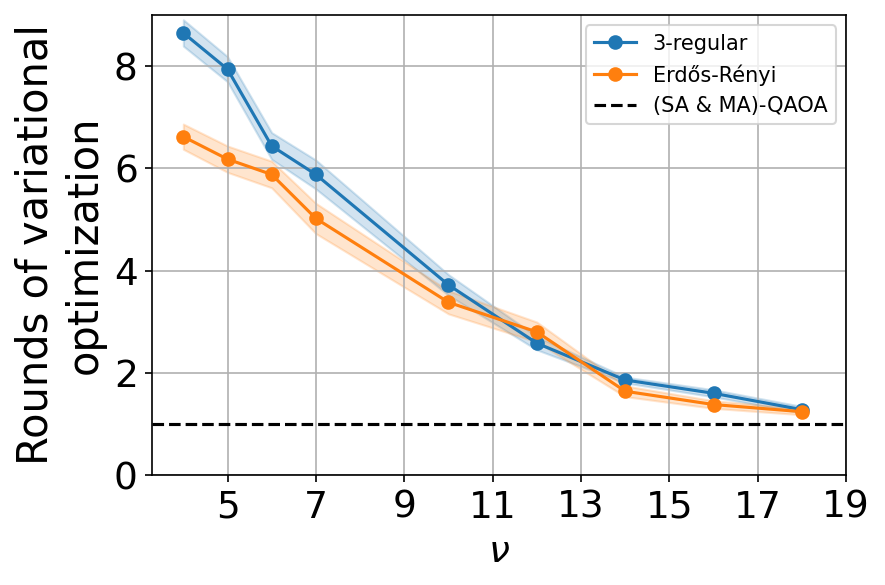

In [169]:
plot_time_to_convergence(d3_data, None, p50_data, None, savefig='figures/ACM/time_to_convergence.pdf')

# Measure gate counts for Erdos-Renyi graphs

In [53]:
k = 1
p50_data = {'$p=1$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P1', 'p50', k=k),
            '$p=5$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P5', 'p50', k=k),
            '$p=10$ SA-QAOA': load_qaoa_data('qaoa_IPM0_P10', 'p50', k=k),
            '$p=1$ MA-QAOA':  load_qaoa_data('qaoa_IPM1_P1', 'p50', k=k),
            r'$\nu=5$ DQVA': load_dqva_data('dqva_5_partial_mixers', 'p50', k=k),
            r'$\nu=7$ DQVA': load_dqva_data('dqva_7_partial_mixers', 'p50', k=k),
            r'$\nu=10$ DQVA': load_dqva_data('dqva_10_partial_mixers', 'p50', k=k),
            r'$\nu=12$ DQVA': load_dqva_data('dqva_12_partial_mixers', 'p50', k=k),
            r'$\nu=14$ DQVA': load_dqva_data('dqva_14_partial_mixers', 'p50', k=k),
            r'$\nu=18$ DQVA': load_dqva_data('dqva_18_partial_mixers', 'p50', k=k)}

In [103]:
for key, data in p50_data.items():
    print(key)
    total_num_graphs = len(data)
    total_gate_counts = {}
    for sim in data:
        gate_counts = {}
        if 'QAOA' in key:
            G = qcopt.graph_funcs.graph_from_file('/'.join(sim['graph'].split('/')[-3:]))
            
            for node, neighbors in G.degree:
                try:
                    gate_counts[neighbors] += 1
                except KeyError:
                    gate_counts[neighbors] = 1
        else:
            G = qcopt.graph_funcs.graph_from_file('/'.join(sim['graph'].split('/')[-3:]))
            history = sim['out'][-1]
            for mixer_round in history:
                mixer_round_avg_counts = {}
                for inner_round in mixer_round:
                    #print(inner_round)
                    init_state = list(reversed(inner_round['init_state']))
                    mixer_order = inner_round['mixer_order']
                    num_partial_mixers = inner_round['num_params'] - 1
                    hot_nodes = []
                    for node in mixer_order:
                        if init_state[node] == '0' and len(hot_nodes) < num_partial_mixers:
                            hot_nodes.append(node)
                    #print(hot_nodes)
                    for node in hot_nodes:
                        try:
                            mixer_round_avg_counts[G.degree(node)] += 1
                        except KeyError:
                            mixer_round_avg_counts[G.degree(node)] = 1
                #print(G.degree)
                mixer_round_avg_counts = {degree: count / len(mixer_round) for degree, count in mixer_round_avg_counts.items()}
                #print(mixer_round_avg_counts)
                
                for degree, count in mixer_round_avg_counts.items():
                    try:
                        gate_counts[degree] += count / len(history)
                    except KeyError:
                        gate_counts[degree] = count / len(history)
                
            #print(gate_counts)
            #print(sum(gate_counts.values()))
                    
        for num_neighbors, count in gate_counts.items():
            try:
                total_gate_counts[num_neighbors] += count
            except KeyError:
                total_gate_counts[num_neighbors] = count
        
    total_gate_counts = {degree: total_gate_counts[degree] / total_num_graphs for degree in sorted(total_gate_counts)}
    if 'QAOA' in key:
        p = int(key.split()[0].strip('$p='))
        total_gate_counts = {degree: count * p for degree, count in total_gate_counts.items()}
        
    print(total_gate_counts)
    print(sum(total_gate_counts.values()))
    print()

$p=1$ SA-QAOA
{3: 0.08, 4: 0.16, 5: 0.38, 6: 0.94, 7: 2.14, 8: 2.9, 9: 3.74, 10: 3.7, 11: 2.84, 12: 1.62, 13: 0.96, 14: 0.42, 15: 0.06, 16: 0.06}
20.0

$p=5$ SA-QAOA
{3: 0.4, 4: 0.8, 5: 1.9, 6: 4.699999999999999, 7: 10.700000000000001, 8: 14.5, 9: 18.700000000000003, 10: 18.5, 11: 14.2, 12: 8.100000000000001, 13: 4.8, 14: 2.1, 15: 0.3, 16: 0.3}
99.99999999999999

$p=10$ SA-QAOA
{3: 0.8, 4: 1.6, 5: 3.8, 6: 9.399999999999999, 7: 21.400000000000002, 8: 29.0, 9: 37.400000000000006, 10: 37.0, 11: 28.4, 12: 16.200000000000003, 13: 9.6, 14: 4.2, 15: 0.6, 16: 0.6}
199.99999999999997

$p=1$ MA-QAOA
{3: 0.08, 4: 0.16, 5: 0.38, 6: 0.94, 7: 2.14, 8: 2.9, 9: 3.74, 10: 3.7, 11: 2.84, 12: 1.62, 13: 0.96, 14: 0.42, 15: 0.06, 16: 0.06}
20.0

$\nu=5$ DQVA
{3: 0.006111111111111111, 4: 0.011666666666666667, 5: 0.059444444444444446, 6: 0.14388888888888887, 7: 0.32499999999999996, 8: 0.5369444444444444, 9: 0.7130555555555556, 10: 0.7727777777777779, 11: 0.6697222222222223, 12: 0.4105555555555555, 13: 0.2452